### Single-Phase Flow Simulator (3D - Compressible flow / FIM ) - Revised 06/07/2020
* **Fully Implicit Method : Newton-Raphson**
* **Developed by Kittipong Limchuchua**

*This is a 3D simulator in Cartesian coordinate (The example run has 3 layers)*

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import xlrd

workbook_name = 'CH8_reservoir prop (3D gas).xlsx'
#importing data box
Nx = 12
Ny = 9
Nz = 3
t = 5
dt = 0.5 #days

# reservoir properties
pi = 7750
p_ref = 14.7
cr = 0 #5e-8
calpha = 5.6146
cbeta = 1.127e-3
Z_datum = 9300

#PVT properties
p_sc = 14.7
T_sc = 520
Mw_air = 28.97
R_const = 10.732
Mw_gas = 22.836
SGg = Mw_gas/Mw_air
T_res = 190 + 460
Rconst = 10.732

#array matrix for reservoir properties
dx = np.zeros((Nz,Ny,Nx))
dy = np.zeros((Nz,Ny,Nx))
kx = np.zeros((Nz,Ny,Nx))
ky = np.zeros((Nz,Ny,Nx))
kz = np.zeros((Nz,Ny,Nx))
Ax = np.zeros((Nz,Ny,Nx))
Ay = np.zeros((Nz,Ny,Nx))
Az = np.zeros((Nz,Ny,Nx))
phi = np.zeros((Nz,Ny,Nx))
phi_ref = np.zeros((Nz,Ny,Nx))
h = np.zeros((Nz,Ny,Nx))
top = np.zeros((Nz,Ny,Nx))
bottom = np.zeros((Nz,Ny,Nx))
middle = np.zeros((Nz,Ny,Nx))
null = np.zeros((Nz,Ny,Nx))
null_im = []

p = np.zeros((Nz,Ny,Nx))
p_new = np.zeros((Nz,Ny,Nx))
p_inner = np.zeros((Nz,Ny,Nx))
qgsc = np.zeros((Nz,Ny,Nx))
pwf = np.zeros((Nz,Ny,Nx))
Jw = np.zeros((Nz,Ny,Nx))
Jw_switch = np.zeros((Nz,Ny,Nx))

In [2]:
# Gas property Generator
def zg(P,T,SGg):
    
    P_pr = P/P_critical(SGg)
    T_pr = T/T_critical(SGg)
    
    #P_pr = P/738.44
    #T_pr = T/418.38
    
    A1 = 0.3265         
    A2 = -1.07          
    A3 = -0.5339        
    A4 = 0.01569        
    A5 = -0.05165        
    A6 = 0.5475
    A7 = -0.7361       
    A8 = 0.1844         
    A9 = 0.1056         
    A10 = 0.6134        
    A11 = 0.721
        
    C1 = A1 + A2 / T_pr + A3 / (T_pr * T_pr * T_pr) + A4 / (T_pr * T_pr * T_pr * T_pr) + A5 / (T_pr * T_pr * T_pr * T_pr * T_pr)
    C2 = A6 + A7 / T_pr + A8 / (T_pr * T_pr)
    C3 = A9 * (A7 / T_pr + A8 / (T_pr * T_pr))

    Ze = 1
    for i in range(0,100):
        rho_pr = 0.27 * (P_pr / (Ze * T_pr))
        C4 = A11 * rho_pr * rho_pr
        Zc = 1 + C1 * rho_pr + C2 * rho_pr * rho_pr - C3 * (rho_pr * rho_pr * rho_pr * rho_pr * rho_pr) + A10 * (1 + C4) * (rho_pr * rho_pr / (T_pr * T_pr * T_pr)) * np.exp(-C4)
        if (np.abs(Ze - Zc) < 0.001):
            break
        else:
            fz = Ze - Zc
            dfdZ = 1 + (rho_pr * rho_pr / Ze) * (C1 / rho_pr + 2 * C2 - 5 * C3 * (rho_pr * rho_pr * rho_pr) + 2 * A10 * np.exp(-C4) * (1 + C4 - C4 * C4) / (T_pr * T_pr * T_pr))
            Ze = Ze - fz / dfdZ
    
    return Zc


def T_critical(SGg):  #Sutton
    return 169.2 + 349.5 * SGg - 74 * SGg * SGg 
def P_critical(SGg): #Sutton
    return 756.8 - 131 * SGg - 3.6 * SGg**2
def T_reduced(T,SGg): #T in Rankine
    return T/T_critical(SGg)
def P_reduced(P,SGg): #T in Rankine
    return P/P_critical(SGg)

def cal_rhog(P,T,SGg):
    Mwg = SGg * Mw_air
    z = zg(P,T,SGg)
    return P*Mwg/z/R_const/T

def cal_viscg(P,T,SGg):
    z = zg(P,T,SGg)
    gasdensPT = cal_rhog(P,T,SGg)
    gasdensPT = gasdensPT * 1000 / (2.20462262184878 * ((0.3048 * 100) ** 3)) 
    Mwg = SGg * Mw_air
    XK = (9.379 + 0.01607 * Mwg) * ((T ** 1.5) / (209.2 + 19.26 * Mwg + T))
    X = 3.448 + 986.4 / T + 0.01009 * Mwg
    Y = 2.447 - 0.2224 * X
    return (XK / 10000) * np.exp(X * (gasdensPT ** Y))

def cal_cg(P,T,SGg):
    dP = 1
    z_left2 = zg(P-2*dP,T,SGg)
    z_left1 = zg(P-dP,T,SGg)
    z_cen = zg(P,T,SGg)
    z_right1 = zg(P+dP,T,SGg)
    z_right2 = zg(P+2*dP,T,SGg)
    dzdP = (z_right1-z_left1)/2/dP
    #dzdP = (-z_left2+8*z_left1-8*z_right1+z_right2)/12/dP
    return 1/P-1/z_cen*dzdP
    
def cal_Bg(P,T,SGg):
    Bg = p_sc/T_sc*zg(P,T,SGg)*T/P
    return Bg/5.6146

#for testing purpose
#print(zg(5000,T_res,SGg))
#print(cal_Bg(5000,T_res,SGg))
#print(cal_viscg(5000,T_res,SGg))
#print(cal_rhog(5000,T_res,SGg))
#print(cal_rhog(14.7,520,SGg))
#print(cal_cg(5000,T_res,SGg))

In [3]:
#important function
def cal_phi(p,p_ref,phi_ref,cr):
    return phi_ref*(1+cr*(p-p_ref))

def id_tran(iz,iy,ix):
    return ix + Nx*iy + Nx*Ny*iz

def Jw_cal(dx,dy,kx,ky,h,viscg,Bg,rw,skin):
    req = 0.28*np.sqrt(np.sqrt(ky/kx)*dx**2+np.sqrt(kx/ky)*dy**2)/((ky/kx)**0.25+(kx/ky)**0.25)
    return 2*np.pi*cbeta*np.sqrt(kx*ky)*h/viscg/Bg/(np.log(req/rw)+skin)

def p_res_average_cal(p):
    # MBE check
    p_res_num = 0
    p_res_deno = 0
    for ix in range (0,Nx):
        for iy in range(0,Ny):
            if (null[iz,iy,ix] != 0):
                p_res_num += dx[iz,iy,ix]*dy[iz,iy,ix]*h[iz,iy,ix]*cal_phi(p[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)*p[iz,iy,ix]
                p_res_deno += dx[iz,iy,ix]*dy[iz,iy,ix]*h[iz,iy,ix]*cal_phi(p[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)
    return p_res_num/p_res_deno

#pressure initialization (gravitational equilibrium)
def pressure_initializer(Z,p_datum,Z_datum):
    p_mid = p_datum
    dp_dZ_mid =  cal_rhog(p_mid,T_res,SGg)/144
    p_cal = p_datum + dp_dZ_mid*(Z-Z_datum)
    p_mid = (p_datum+p_cal)/2

    while True:
        dp_dZ_mid =  cal_rhog(p_mid,T_res,SGg)/144
        p_cal_new = p_datum + dp_dZ_mid*(Z-Z_datum)
        if abs(p_cal_new-p_cal) < 0.0001:
            break
        p_cal = p_cal_new
        p_mid = (p_datum+p_cal_new)/2
    return p_cal_new

#print(pressure_initializer(9270,7750,9300))

In [4]:
#initialization
res_Excel = xlrd.open_workbook(workbook_name)

for ix in range (0,Nx):
    for iy in range(0,Ny):       
        for iz in range(0,Nz):
            dx[:,iy,ix] = res_Excel.sheet_by_name('dx').cell(iy,ix).value
            dy[:,iy,ix] = res_Excel.sheet_by_name('dy').cell(iy,ix).value

            if iz == 0:

                kx[iz,iy,ix] = res_Excel.sheet_by_name('kx1').cell(iy,ix).value
                ky[iz,iy,ix] = res_Excel.sheet_by_name('ky1').cell(iy,ix).value
                kz[iz,iy,ix] = res_Excel.sheet_by_name('kz1').cell(iy,ix).value
                phi[iz,iy,ix] = res_Excel.sheet_by_name('phi1').cell(iy,ix).value
                phi_ref[iz,iy,ix] = res_Excel.sheet_by_name('phi1').cell(iy,ix).value
                top[iz,iy,ix] = res_Excel.sheet_by_name('T1').cell(iy,ix).value
                bottom[iz,iy,ix] = res_Excel.sheet_by_name('T2').cell(iy,ix).value
                null[iz,iy,ix] = res_Excel.sheet_by_name('null1').cell(iy,ix).value

            if iz == 1:

                kx[iz,iy,ix] = res_Excel.sheet_by_name('kx2').cell(iy,ix).value
                ky[iz,iy,ix] = res_Excel.sheet_by_name('ky2').cell(iy,ix).value
                kz[iz,iy,ix] = res_Excel.sheet_by_name('kz2').cell(iy,ix).value
                phi[iz,iy,ix] = res_Excel.sheet_by_name('phi2').cell(iy,ix).value
                phi_ref[iz,iy,ix] = res_Excel.sheet_by_name('phi2').cell(iy,ix).value
                top[iz,iy,ix] = res_Excel.sheet_by_name('T2').cell(iy,ix).value
                bottom[iz,iy,ix] = res_Excel.sheet_by_name('T3').cell(iy,ix).value
                null[iz,iy,ix] = res_Excel.sheet_by_name('null2').cell(iy,ix).value

            if iz == 2:

                kx[iz,iy,ix] = res_Excel.sheet_by_name('kx3').cell(iy,ix).value
                ky[iz,iy,ix] = res_Excel.sheet_by_name('ky3').cell(iy,ix).value
                kz[iz,iy,ix] = res_Excel.sheet_by_name('kz3').cell(iy,ix).value
                phi[iz,iy,ix] = res_Excel.sheet_by_name('phi3').cell(iy,ix).value
                phi_ref[iz,iy,ix] = res_Excel.sheet_by_name('phi3').cell(iy,ix).value
                top[iz,iy,ix] = res_Excel.sheet_by_name('T3').cell(iy,ix).value
                bottom[iz,iy,ix] = res_Excel.sheet_by_name('B3').cell(iy,ix).value
                null[iz,iy,ix] = res_Excel.sheet_by_name('null3').cell(iy,ix).value


            h[iz,iy,ix] = bottom[iz,iy,ix]-top[iz,iy,ix]
            middle[iz,iy,ix] = (top[iz,iy,ix] + bottom[iz,iy,ix])/2
            Ax[iz,iy,ix] = dy[iz,iy,ix]*h[iz,iy,ix]
            Ay[iz,iy,ix] = dx[iz,iy,ix]*h[iz,iy,ix]
            Az[iz,iy,ix] = dx[iz,iy,ix]*dy[iz,iy,ix]

            if null[iz,iy,ix] == 1:
                #pressure distribution (initialization)
                p[iz,iy,ix] = pressure_initializer(middle[iz,iy,ix],pi,Z_datum)
            
#print(p)

In [5]:
# Well information
rw = np.zeros((Nz,Ny,Nx))

def well_assignment(iz,iy,ix,prod_type,argument,rw_argument):
    if prod_type == 'const_rate':
        qgsc[iz,iy,ix] = argument
        rw[iz,iy,ix] = rw_argument
        
    if prod_type == 'const_BHP':
        pwf[iz,iy,ix] = argument
        Jw_switch[iz,iy,ix] = 1
        rw[iz,iy,ix] = rw_argument

#W2
#qgsc[0,2,8] = -3e+6
well_assignment(0,2,8,'const_rate',-3e+6,0.25)
#W3
#pwf[0,3,3] = 6000
well_assignment(0,3,3,'const_BHP',6000,0.25)

#rw_3_3 = 0.25
#rw_2_8 = 0.25


#reporting-general settings 

#N_step = 68
#dt_report = [0] + [0.0625]*4 + [0.125]*2 + [0.25]*4 + [0.5]*17 + [1]*40

#N_step = 18
#dt_report = [0,0.0625,0.0625,0.0625,0.0625,0.125,0.125,0.25,0.25,0.25,0.25,0.5,0.5,0.5,0.5,0.5,0.5,0.5]

#N_step = 16
#dt_report = [0,0.125,0.125,0.125,0.125,0.25,0.25,0.25,0.25,0.5,0.5,0.5,0.5,0.5,0.5,0.5]

#N_step = 14
#dt_report = [0,0.25,0.25,0.25,0.25,0.25,0.25,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]

#N_step = 11
#dt_report = [0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]


N_step = 11
dt_report = [0] + [0.5]*10
t_report = np.zeros(N_step)
p_res_average = np.zeros(N_step)
MB_error = np.zeros(N_step)


#reporting-production settings
p_28 = np.zeros(N_step)
Jw_28 = np.zeros(N_step)
pwf_28 = np.zeros(N_step)

p_33 = np.zeros(N_step)
Jw_33 = np.zeros(N_step)
q_33 = np.zeros(N_step)


p_28[0] = p[0,2,8]

#plot settings
plt_max = 4000
plt_min = 3970

        
t_cum = 0
viscg = np.zeros((Nz,Ny,Nx))
Bg = np.zeros((Nz,Ny,Nx))
rhog = np.zeros((Nz,Ny,Nx))
cg = np.zeros((Nz,Ny,Nx))

A_matrix = np.zeros((Nx*Ny*Nz,Nx*Ny*Nz))
B_matrix = np.zeros((Nx*Ny*Nz,1))
soln_matrix = np.zeros((Nx*Ny*Nz,1))

A_matrix_R = np.zeros((Nx*Ny*Nz,Nx*Ny*Nz))
B_matrix_R = np.zeros((Nx*Ny*Nz,1))
soln_matrix_R = np.zeros((Nx*Ny*Nz,1))
residual_dp = np.zeros((Nz,Ny,Nx))

In [6]:
# loop calculation


#Residual function (R)

def R(iz,iy,ix,diff_dir):
     
    R_e = 0.00001 #increment for derivative calculation
    if diff_dir == 'C':
        p_C = p_inner[iz,iy,ix] + R_e
    else:
        p_C = p_inner[iz,iy,ix] 
        
    viscg_C = cal_viscg(p_C,T_res,SGg)
    Bg_C = cal_Bg(p_C,T_res,SGg)
    rhog_C = cal_rhog(p_C,T_res,SGg)
    cg_C = cal_cg(p_C,T_res,SGg)
    
    #for (i-1,j,k) grid bock (W-direction)
    if (ix == 0) or (null[iz,iy,ix]==0):
        p_W = 0
        viscg_W = 0
        Bg_W = 0
        rhog_W = 0
        tran_W_R = 0
        tran_Wg_R = 0
    else:
        if diff_dir == 'W':
            p_W = p_inner[iz,iy,ix-1] + R_e
        else:
            p_W = p_inner[iz,iy,ix-1]
            
        viscg_W = cal_viscg(p_W,T_res,SGg)
        Bg_W = cal_Bg(p_W,T_res,SGg)
        rhog_W = cal_rhog(p_W,T_res,SGg)
        tran_W_R_const = cbeta*2/(dx[iz,iy,ix-1]/Ax[iz,iy,ix-1]/kx[iz,iy,ix-1]+dx[iz,iy,ix]/Ax[iz,iy,ix]/kx[iz,iy,ix])
        tran_W_R = tran_W_R_const/(viscg_W+viscg_C)*2/(Bg_W+Bg_C)*2
        tran_Wg_R = tran_W_R_const*(rhog_W+rhog_C)/2/144
        
     #for (i+1,j,k) grid bock (E-direction)  
    if (ix == Nx-1) or (null[iz,iy,ix]==0):
        p_E = 0
        viscg_E = 0
        Bg_E = 0
        rhog_E = 0
        tran_E_R = 0
        tran_Eg_R = 0
    else:
        if diff_dir == 'E':
            p_E = p_inner[iz,iy,ix+1] + R_e
        else:
            p_E = p_inner[iz,iy,ix+1] 

        viscg_E = cal_viscg(p_E,T_res,SGg)
        Bg_E = cal_Bg(p_E,T_res,SGg)
        rhog_E = cal_rhog(p_E,T_res,SGg)
        tran_E_R_const = cbeta*2/(dx[iz,iy,ix+1]/Ax[iz,iy,ix+1]/kx[iz,iy,ix+1]+dx[iz,iy,ix]/Ax[iz,iy,ix]/kx[iz,iy,ix])
        tran_E_R = tran_E_R_const/(viscg_E+viscg_C)*2/(Bg_E+Bg_C)*2
        tran_Eg_R = tran_E_R_const*(rhog_E+rhog_C)/2/144
    
     #for (i,j-1,k) grid bock (N-direction)
    if (iy == 0) or (null[iz,iy,ix]==0):
        p_N = 0
        viscg_N = 0
        Bg_N = 0
        rhog_N = 0
        tran_N_R = 0
        tran_Ng_R = 0
    else:
        if diff_dir == 'N':
            p_N = p_inner[iz,iy-1,ix] + R_e
        else:
            p_N = p_inner[iz,iy-1,ix]
            
        viscg_N = cal_viscg(p_N,T_res,SGg)
        Bg_N = cal_Bg(p_N,T_res,SGg)
        rhog_N = cal_rhog(p_N,T_res,SGg)
        tran_N_R_const = cbeta*2/(dy[iz,iy-1,ix]/Ay[iz,iy-1,ix]/ky[iz,iy-1,ix]+dy[iz,iy,ix]/Ay[iz,iy,ix]/ky[iz,iy,ix])
        tran_N_R = tran_N_R_const/(viscg_N+viscg_C)*2/(Bg_N+Bg_C)*2
        tran_Ng_R = tran_N_R_const*(rhog_N+rhog_C)/2/144
    
     #for (i,j+1,k) grid bock (S-direction)
    if (iy == Ny-1) or (null[iz,iy,ix]==0):
        p_S = 0
        viscg_S = 0
        Bg_S = 0
        rhog_S = 0
        tran_S_R = 0
        tran_Sg_R = 0
    else:
        if diff_dir == 'S':
            p_S = p_inner[iz,iy+1,ix] + R_e
        else:
            p_S = p_inner[iz,iy+1,ix]
            
        viscg_S = cal_viscg(p_S,T_res,SGg)
        Bg_S = cal_Bg(p_S,T_res,SGg)
        rhog_S = cal_rhog(p_S,T_res,SGg)
        tran_S_R_const = cbeta*2/(dy[iz,iy+1,ix]/Ay[iz,iy+1,ix]/ky[iz,iy+1,ix]+dy[iz,iy,ix]/Ay[iz,iy,ix]/ky[iz,iy,ix])
        tran_S_R = tran_S_R_const/(viscg_S+viscg_C)*2/(Bg_S+Bg_C)*2
        tran_Sg_R = tran_S_R_const*(rhog_S+rhog_C)/2/144
        
    #Add 3D
    #for (i,j,k-1) grid bock (A-direction)
    if (iz == 0) or (null[iz,iy,ix]==0):
        p_A = 0
        viscg_A = 0
        Bg_A = 0
        rhog_A = 0
        tran_A_R = 0
        tran_Ag_R = 0
    else:
        if diff_dir == 'A':
            p_A = p_inner[iz-1,iy,ix] + R_e
        else:
            p_A = p_inner[iz-1,iy,ix]
            
        viscg_A = cal_viscg(p_A,T_res,SGg)
        Bg_A = cal_Bg(p_A,T_res,SGg)
        rhog_A = cal_rhog(p_A,T_res,SGg)
        tran_A_R_const = cbeta*2/(h[iz-1,iy,ix]/Az[iz-1,iy,ix]/kz[iz-1,iy,ix]+h[iz,iy,ix]/Az[iz,iy,ix]/kz[iz,iy,ix])
        tran_A_R = tran_A_R_const/(viscg_A+viscg_C)*2/(Bg_A+Bg_C)*2
        tran_Ag_R = tran_A_R_const*(rhog_A+rhog_C)/2/144

        
   #Add 3D
   #for (i,j,k+1) grid bock (A-direction)
    if (iz == Nz-1) or (null[iz,iy,ix]==0):
        p_B = 0
        viscg_B = 0
        Bg_B = 0
        rhog_B = 0
        tran_B_R = 0
        tran_Bg_R = 0
    else:
        if diff_dir == 'B':
            p_B = p_inner[iz+1,iy,ix] + R_e
        else:
            p_B = p_inner[iz+1,iy,ix]
            
        viscg_B = cal_viscg(p_B,T_res,SGg)
        Bg_B = cal_Bg(p_B,T_res,SGg)
        rhog_B = cal_rhog(p_B,T_res,SGg)
        tran_B_R_const = cbeta*2/(h[iz+1,iy,ix]/Az[iz+1,iy,ix]/kz[iz+1,iy,ix]+h[iz,iy,ix]/Az[iz,iy,ix]/kz[iz,iy,ix])
        tran_B_R = tran_B_R_const/(viscg_B+viscg_C)*2/(Bg_B+Bg_C)*2
        tran_Bg_R = tran_B_R_const*(rhog_B+rhog_C)/2/144
   
    
    Jw_C = 0
    #only for grid(0,3,3)
    #if iz == 0 and iy == 3 and ix ==3:
    if Jw_switch[iz,iy,ix] != 0:
        #Jw_C = Jw_cal(dx[0,3,3],dy[0,3,3],kx[0,3,3],ky[0,3,3],h[0,3,3],viscg_C,Bg_C,rw_3_3,0)
        Jw_C = Jw_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],h[iz,iy,ix],viscg_C,Bg_C,rw[iz,iy,ix],0)
    
    
    tau_term_R = dx[iz,iy,ix]*dy[iz,iy,ix]*h[iz,iy,ix]*phi[iz,iy,ix]*cg_C/calpha/Bg_C
    tran_C_R = -(tran_W_R + tran_E_R + tran_S_R + tran_N_R + tran_A_R + tran_B_R + tau_term_R /dt + Jw_C)
    tran_Cg_R = -(tran_Wg_R + tran_Eg_R + tran_Sg_R + tran_Ng_R + tran_Ag_R + tran_Bg_R)
    
    Qg_term_R = 0
    if ix != 0:
        Qg_term_R += middle[iz,iy,ix-1]*tran_Wg_R
    if ix != Nx-1:
        Qg_term_R += middle[iz,iy,ix+1]*tran_Eg_R
    if iy != 0:
        Qg_term_R += middle[iz,iy-1,ix]*tran_Ng_R
    if iy != Ny-1:  
        Qg_term_R += middle[iz,iy+1,ix]*tran_Sg_R
    if iz != 0:
        Qg_term_R += middle[iz-1,iy,ix]*tran_Ag_R
    if iz != Nz-1:  
        Qg_term_R += middle[iz+1,iy,ix]*tran_Bg_R
                
    Qg_term_R += middle[iz,iy,ix]*tran_Cg_R
    Q_term_R = -(tau_term_R/dt*p[iz,iy,ix] + qgsc[iz,iy,ix] + pwf[iz,iy,ix] * Jw_C - Qg_term_R)

    sum_R = Q_term_R - (p_W*tran_W_R + p_E*tran_E_R + p_N*tran_N_R + p_S*tran_S_R + p_C*tran_C_R + p_A*tran_A_R + p_B*tran_B_R)
    
    if (null[iz,iy,ix]==0):
        sum_R = 0
    return sum_R

#Residual-derivative (dR/dP)
def dR_dp(iz,iy,ix,diff_dir):
    
    R_e = 0.00001
    
    if diff_dir == 'C':
         dR_dp = (R(iz,iy,ix,'C')-R(iz,iy,ix,'0'))/R_e
    if diff_dir == 'W':
         dR_dp = (R(iz,iy,ix,'W')-R(iz,iy,ix,'0'))/R_e
    if diff_dir == 'E':
         dR_dp = (R(iz,iy,ix,'E')-R(iz,iy,ix,'0'))/R_e
    if diff_dir == 'N':
         dR_dp = (R(iz,iy,ix,'N')-R(iz,iy,ix,'0'))/R_e
    if diff_dir == 'S':
         dR_dp = (R(iz,iy,ix,'S')-R(iz,iy,ix,'0'))/R_e  
    if diff_dir == 'A':
         dR_dp = (R(iz,iy,ix,'A')-R(iz,iy,ix,'0'))/R_e
    if diff_dir == 'B':
         dR_dp = (R(iz,iy,ix,'B')-R(iz,iy,ix,'0'))/R_e  
    return dR_dp

 ##########################  
#SIMULATOR-MATRIX SOLVER

#timestep zero

report_counter = 0

viscg[iz,iy,ix] = cal_viscg(p[iz,iy,ix],T_res,SGg)
rhog[iz,iy,ix] = cal_rhog(p[iz,iy,ix],T_res,SGg)
cg[iz,iy,ix] = cal_cg(p[iz,iy,ix],T_res,SGg)
Bg[iz,iy,ix] = cal_Bg(p[iz,iy,ix],T_res,SGg)
phi[iz,iy,ix] = cal_phi(p[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)
if Jw_switch[iz,iy,ix] != 0:
#Jw[0,3,3] = Jw_cal(dx[0,3,3],dy[0,3,3],kx[0,3,3],ky[0,3,3],h[0,3,3],viscg[0,3,3],Bg[0,3,3],rw_3_3,0)
    Jw[iz,iy,ix] = Jw_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],h[iz,iy,ix],viscg[iz,iy,ix],Bg[iz,iy,ix],rw[iz,iy,ix],0)

p_res_average[report_counter] = p_res_average_cal(p)
t_report[report_counter] = 0

p_28[report_counter] = p[0,2,8]
Jw_28[report_counter] = Jw_cal(dx[0,2,8],dy[0,2,8],kx[0,2,8],ky[0,2,8],h[0,2,8],viscg[0,2,8],Bg[0,2,8],rw[0,2,8],0)
pwf_28[report_counter] = p[0,2,8]
    
p_33[report_counter] = p[0,3,3]
q_33[report_counter] = 0
Jw_33[report_counter] = Jw[0,3,3]

t_cum = 0
report_counter = 1

while report_counter <= N_step-1:

    
    dt = dt_report[report_counter]  #assign time step as specified in the array
    t_cum += dt
    t_report[report_counter] = t_cum
    
    print('--')
    print(t_cum)
    print('--')
    print(t_report[report_counter])
    print('--')
    print(dt)
    print('--')
    
    for inner_counter in range(0,5):

        for ix in range (0,Nx):
            for iy in range(0,Ny):
                for iz in range(0,Nz):
                    if inner_counter == 0:
                        viscg[iz,iy,ix] = cal_viscg(p[iz,iy,ix],T_res,SGg)
                        rhog[iz,iy,ix] = cal_rhog(p[iz,iy,ix],T_res,SGg)
                        cg[iz,iy,ix] = cal_cg(p[iz,iy,ix],T_res,SGg)
                        Bg[iz,iy,ix] = cal_Bg(p[iz,iy,ix],T_res,SGg)
                        phi[iz,iy,ix] = cal_phi(p[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)
                        
                        if Jw_switch[iz,iy,ix] != 0:
                        #Jw[0,3,3] = Jw_cal(dx[0,3,3],dy[0,3,3],kx[0,3,3],ky[0,3,3],h[0,3,3],viscg[0,3,3],Bg[0,3,3],rw_3_3,0)
                            Jw[iz,iy,ix] = Jw_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],h[iz,iy,ix],viscg[iz,iy,ix],Bg[iz,iy,ix],rw[iz,iy,ix],0)

                        p_inner = p
                    else:
                        viscg[iz,iy,ix] = cal_viscg(p_inner[iz,iy,ix],T_res,SGg)
                        rhog[iz,iy,ix] = cal_rhog(p_inner[iz,iy,ix],T_res,SGg)
                        cg[iz,iy,ix] = cal_cg(p_inner[iz,iy,ix],T_res,SGg)
                        Bg[iz,iy,ix] = cal_Bg(p_inner[iz,iy,ix],T_res,SGg)
                        phi[iz,iy,ix] = cal_phi(p_inner[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)
                        
                        if Jw_switch[iz,iy,ix] != 0:
                        #Jw[0,3,3] = Jw_cal(dx[0,3,3],dy[0,3,3],kx[0,3,3],ky[0,3,3],h[0,3,3],viscg[0,3,3],Bg[0,3,3],rw_3_3,0)
                            Jw[iz,iy,ix] = Jw_cal(dx[iz,iy,ix],dy[iz,iy,ix],kx[iz,iy,ix],ky[iz,iy,ix],h[iz,iy,ix],viscg[iz,iy,ix],Bg[iz,iy,ix],rw[iz,iy,ix],0)

        print(p_inner)

        
        #Jacobian generator
        for ix in range (0,Nx):
            for iy in range(0,Ny):
                for iz in range(0,Nz):

                    im = id_tran(iz,iy,ix)
                    if null[iz,iy,ix] == 0:
                        null_im.append(im)
                    A_matrix_R[im,im] = dR_dp(iz,iy,ix,'C')

                    if (im-1)>= 0:
                        A_matrix_R[im,im-1] = dR_dp(iz,iy,ix,'W')

                    if (im+1)<= (Nx*Ny*Nz-1):
                        A_matrix_R[im,im+1] = dR_dp(iz,iy,ix,'E')

                    if (im-Nx)>= 0:
                        A_matrix_R[im,im-Nx] = dR_dp(iz,iy,ix,'N')

                    if (im+Nx)<= (Nx*Ny*Nz-1):
                        A_matrix_R[im,im+Nx] = dR_dp(iz,iy,ix,'S')
                        
                    if (im-Nx*Ny)>= 0:
                        A_matrix_R[im,im-Nx*Ny] = dR_dp(iz,iy,ix,'A')

                    if (im+Nx*Ny)<= (Nx*Ny*Nz-1):
                        A_matrix_R[im,im+Nx*Ny] = dR_dp(iz,iy,ix,'B')

                    B_matrix_R[im,0] = R(iz,iy,ix,'0')

        null_im.sort()
        #print(null_im)
        A_matrix_1_R = np.delete(A_matrix_R,null_im,0)
        A_matrix_2_R = np.delete(A_matrix_1_R,null_im,1)
        B_matrix_1_R = np.delete(B_matrix_R,null_im,0)  
        
        soln_matrix_R = np.dot(np.linalg.inv(A_matrix_2_R),B_matrix_1_R)

        rev_counter = 0
        for iz in range(0,Nz):
            for iy in range (0,Ny):
                for ix in range(0,Nx):
                
                    
                    if null[iz,iy,ix] == 0:
                        residual_dp[iz,iy,ix] = 0
                    else:
                        residual_dp[iz,iy,ix] = soln_matrix_R[rev_counter,0]
                        rev_counter += 1
   
        p_inner =  p_inner - residual_dp
        
        # MBE check (Material-balance check)
        IMB_num = 0
        IMB_deno = 0
        for ix in range (0,Nx):
            for iy in range(0,Ny):
                for iz in range(0,Nz):
                    if (null[iz,iy,ix] != 0):
                        IMB_num += dx[iz,iy,ix]*dy[iz,iy,ix]*h[iz,iy,ix]/calpha*(cal_phi(p_inner[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)/cal_Bg(p_inner[iz,iy,ix],T_res,SGg)-cal_phi(p[iz,iy,ix],p_ref,phi_ref[iz,iy,ix],cr)/cal_Bg(p[iz,iy,ix],T_res,SGg))
                    if (qgsc[iz,iy,ix] != 0):
                        IMB_deno += dt*qgsc[iz,iy,ix]

                    if (Jw[iz,iy,ix] != 0 ):
                        IMB_deno += -dt*Jw[iz,iy,ix]*(p_inner[iz,iy,ix]-pwf[iz,iy,ix])
                

        IMB = IMB_num/IMB_deno

        #print(p_new)
        print(IMB)
        #print(p_inner)
        print('')    
    
    p_new = p_inner #assign the last inner iteration to p_new
    p_28[report_counter] = p_new[0,2,8]
    Jw_28[report_counter] = Jw_cal(dx[0,2,8],dy[0,2,8],kx[0,2,8],ky[0,2,8],h[0,2,8],viscg[0,2,8],Bg[0,2,8],rw[0,2,8],0)
    pwf_28[report_counter] = qgsc[0,2,8]/Jw_28[report_counter] + p_28[report_counter]
    
    p_33[report_counter] = p_new[0,3,3]
    q_33[report_counter] = Jw[0,3,3]*(p_new[0,3,3]-pwf[0,3,3])
    Jw_33[report_counter] = Jw[0,3,3]
    p_res_average[report_counter] = p_res_average_cal(p_new)
    MB_error[report_counter] = IMB
    
    report_counter += 1
    
    p[:] = p_new[:]

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars


--
0.5
--
0.5
--
0.5
--
[[[   0.         7747.88679396 7747.88679396 7747.88679396    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7747.88679396 7747.88679396 7747.88679396 7747.88679396 7747.88679396
      0.            0.            0.         7747.88679396 7747.88679396
      0.            0.        ]
  [7747.88679396 7747.88679396 7747.88679396 7747.88679396 7747.88679396
   7747.88679396 7747.88679396 7747.88679396 7747.88679396 7747.88679396
   7747.88679396 7747.88679396]
  [7747.88679396 7747.88679396 7747.88679396 7747.88679396 7747.88679396
   7747.88679396 7747.88679396 7747.88679396 7747.88679396 7747.88679396
   7747.88679396 7747.88679396]
  [7747.88679396 7747.88679396 7747.88679396 7747.88679396 7747.88679396
   7747.88679396 7747.88679396 7747.88679396 7747.88679396 7747.88679396
      0.            0.        ]
  [   0.            0.            0.         7747.88679396 7747.88679396
   7747.88679396 7747.8867939

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars


1.0049142230877703

[[[   0.         7750.80509981 7750.76605532 7750.67665937    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7750.79015537 7750.78651845 7750.74719664 7750.50347247 7750.63750707
      0.            0.            0.         7748.52327428 7750.6163594
      0.            0.        ]
  [7750.78179396 7750.77065597 7750.45749836 7747.72818597 7750.42916594
   7750.67090672 7750.65785326 7749.81716324 7716.48421741 7750.01037859
   7750.75216471 7750.77132088]
  [7750.77126731 7750.62722884 7748.3201498  7700.4491799  7748.56270617
   7750.59803512 7750.68421021 7750.58305249 7749.24371182 7750.68098189
   7750.75086168 7750.75723902]
  [7750.7727018  7750.71224425 7750.41691517 7747.94238031 7750.47274547
   7750.66741199 7750.68592702 7750.64393063 7750.62458873 7750.70258203
      0.            0.        ]
  [   0.            0.            0.         7750.41315614 7750.65462053
   7750.65744151 7750.67235893 775

0.9961003797512612

[[[   0.         7750.80673837 7750.7676744  7750.67827395    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7750.7917801  7750.78817358 7750.74905456 7750.50639644 7750.6392338
      0.            0.            0.         7748.53286441 7750.61835913
      0.            0.        ]
  [7750.78343369 7750.77248726 7750.46120694 7747.74825254 7750.43248726
   7750.67257088 7750.65941805 7749.82165562 7716.61919603 7750.01456267
   7750.75388384 7750.77292498]
  [7750.77296041 7750.62979505 7748.3368418  7700.7554584  7748.57722226
   7750.60019444 7750.68574814 7750.58486504 7749.25074185 7750.68286237
   7750.75246806 7750.7588273 ]
  [7750.77432983 7750.71403087 7750.42058369 7747.9610444  7750.47596484
   7750.66904814 7750.68744139 7750.64544279 7750.62645728 7750.7041516
      0.            0.        ]
  [   0.            0.            0.         7750.41662792 7750.65642359
   7750.65895566 7750.6738573  7750

0.9961003799190032

--
1.0
--
1.0
--
0.5
--
[[[   0.         7750.80673837 7750.7676744  7750.67827395    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7750.7917801  7750.78817358 7750.74905456 7750.50639644 7750.6392338
      0.            0.            0.         7748.53286441 7750.61835913
      0.            0.        ]
  [7750.78343369 7750.77248726 7750.46120694 7747.74825254 7750.43248726
   7750.67257088 7750.65941805 7749.82165562 7716.61919603 7750.01456267
   7750.75388384 7750.77292498]
  [7750.77296041 7750.62979505 7748.3368418  7700.7554584  7748.57722226
   7750.60019444 7750.68574814 7750.58486504 7749.25074185 7750.68286237
   7750.75246806 7750.7588273 ]
  [7750.77432983 7750.71403087 7750.42058369 7747.9610444  7750.47596484
   7750.66904814 7750.68744139 7750.64544279 7750.62645728 7750.7041516
      0.            0.        ]
  [   0.            0.            0.         7750.41662792 7750.65642359
   7750.658

0.9980461021803001

[[[   0.         7751.63559447 7751.60113393 7751.5107758     0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.62661447 7751.60718391 7751.47123258 7750.87678832 7751.41254114
      0.            0.            0.         7746.32130769 7751.19525128
      0.            0.        ]
  [7751.61017921 7751.50766809 7750.55892879 7744.41075026 7750.65654662
   7751.47631482 7751.50084587 7749.47487219 7697.78255191 7749.83154285
   7751.52359651 7751.61530286]
  [7751.57253062 7751.12149073 7745.6835533  7672.12868494 7746.37767031
   7751.2328104  7751.54743537 7751.2668485  7748.04782429 7751.3428691
   7751.58708998 7751.61003914]
  [7751.60304414 7751.46895943 7750.5130006  7744.89487853 7750.73050751
   7751.48693594 7751.5630322  7751.51214239 7751.29231809 7751.54835537
      0.            0.        ]
  [   0.            0.            0.         7750.57191923 7751.39358344
   7751.53308181 7751.55772568 775

0.9980487632656037

[[[   0.         7751.63559447 7751.60113393 7751.5107758     0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.62661447 7751.60718391 7751.47123258 7750.87678834 7751.41254115
      0.            0.            0.         7746.32130775 7751.19525128
      0.            0.        ]
  [7751.61017921 7751.50766809 7750.55892882 7744.41075052 7750.65654665
   7751.47631482 7751.50084587 7749.47487222 7697.78255288 7749.83154287
   7751.52359651 7751.61530286]
  [7751.57253062 7751.12149074 7745.68355351 7672.12868761 7746.37767043
   7751.23281041 7751.54743537 7751.2668485  7748.04782435 7751.3428691
   7751.58708998 7751.61003914]
  [7751.60304414 7751.46895944 7750.51300062 7744.89487878 7750.73050753
   7751.48693594 7751.5630322  7751.51214239 7751.29231809 7751.54835537
      0.            0.        ]
  [   0.            0.            0.         7750.57191926 7751.39358345
   7751.53308181 7751.55772568 775

1.0017156724647889

[[[   0.         7751.86489114 7751.81782554 7751.69168516    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.85902547 7751.80472922 7751.48850122 7750.36842012 7751.46906466
      0.            0.            0.         7742.93583053 7750.9877539
      0.            0.        ]
  [7751.82086094 7751.55770719 7749.66720982 7739.89516707 7749.92294567
   7751.60335612 7751.70678521 7748.27880179 7684.3318546  7748.87445322
   7751.65190796 7751.85581622]
  [7751.73298576 7750.81399064 7741.91339628 7651.22197876 7743.0844746
   7751.11543486 7751.7879091  7751.21956066 7745.97341246 7751.29209485
   7751.80335946 7751.86029672]
  [7751.812457   7751.52177437 7749.56877465 7740.65119674 7750.04740622
   7751.64058955 7751.83003133 7751.74726983 7751.24620669 7751.76338343
      0.            0.        ]
  [   0.            0.            0.         7749.70144818 7751.39264782
   7751.78239895 7751.83647562 7751

0.9987105670057521

[[[   0.         7751.86490452 7751.81785243 7751.69175917    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.85903988 7751.80476228 7751.48868243 7750.36931912 7751.46923135
      0.            0.            0.         7742.94104059 7750.98805552
      0.            0.        ]
  [7751.82088727 7751.55785427 7749.66860595 7739.90524889 7749.92411042
   7751.60346159 7751.70683109 7748.28020438 7684.36484668 7748.87558416
   7751.65197112 7751.85583007]
  [7751.73304754 7750.81457834 7741.92128561 7651.30318105 7743.09109356
   7751.11581233 7751.78793776 7751.21975265 7745.97612894 7751.29226826
   7751.80338226 7751.86030947]
  [7751.81248486 7751.52192848 7749.57021266 7740.66044198 7750.04848423
   7751.64068199 7751.83004906 7751.74730224 7751.2464086  7751.76341385
      0.            0.        ]
  [   0.            0.            0.         7749.70279423 7751.39285699
   7751.78243033 7751.83649169 77

0.9987105670376193

--
2.0
--
2.0
--
0.5
--
[[[   0.         7751.86490452 7751.81785243 7751.69175917    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.85903988 7751.80476228 7751.48868243 7750.36931912 7751.46923135
      0.            0.            0.         7742.94104059 7750.98805552
      0.            0.        ]
  [7751.82088727 7751.55785427 7749.66860595 7739.90524889 7749.92411042
   7751.60346159 7751.70683109 7748.28020438 7684.36484668 7748.87558416
   7751.65197112 7751.85583007]
  [7751.73304754 7750.81457834 7741.92128561 7651.30318105 7743.09109356
   7751.11581233 7751.78793776 7751.21975265 7745.97612894 7751.29226826
   7751.80338226 7751.86030947]
  [7751.81248486 7751.52192848 7749.57021266 7740.66044198 7750.04848423
   7751.64068199 7751.83004906 7751.74730224 7751.2464086  7751.76341385
      0.            0.        ]
  [   0.            0.            0.         7749.70279423 7751.39285699
   7751.7

0.9990622342183295

[[[   0.         7751.91539476 7751.83069603 7751.62295841    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.90831336 7751.794249   7751.20753801 7749.42840598 7751.19582422
      0.            0.            0.         7739.04544254 7750.41537156
      0.            0.        ]
  [7751.83019768 7751.33257114 7748.26781411 7734.99157187 7748.69006041
   7751.45115244 7751.6855022  7746.73829931 7674.03493929 7747.63922816
   7751.56211408 7751.91535666]
  [7751.66680293 7750.14653525 7737.75098105 7634.9282659  7739.37636851
   7750.66885333 7751.81520579 7750.8593027  7743.6212574  7750.95822908
   7751.81731824 7751.92963566]
  [7751.8137285  7751.27133002 7748.05161903 7735.9824939  7748.88082976
   7751.53048116 7751.89861638 7751.75379442 7750.91737662 7751.75908278
      0.            0.        ]
  [   0.            0.            0.         7748.25152862 7751.04182407
   7751.80788084 7751.92032744 77

0.9990632394645946

[[[   0.         7751.91539476 7751.83069603 7751.62295841    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.90831336 7751.794249   7751.20753801 7749.42840599 7751.19582422
      0.            0.            0.         7739.04544254 7750.41537156
      0.            0.        ]
  [7751.83019768 7751.33257114 7748.26781412 7734.99157191 7748.69006041
   7751.45115244 7751.6855022  7746.73829931 7674.03493934 7747.63922816
   7751.56211408 7751.91535666]
  [7751.66680293 7750.14653525 7737.75098111 7634.9282664  7739.37636856
   7750.66885333 7751.81520579 7750.8593027  7743.62125741 7750.95822908
   7751.81731824 7751.92963566]
  [7751.8137285  7751.27133002 7748.05161904 7735.98249393 7748.88082977
   7751.53048116 7751.89861638 7751.75379442 7750.91737662 7751.75908278
      0.            0.        ]
  [   0.            0.            0.         7748.25152863 7751.04182407
   7751.80788084 7751.92032744 77

1.0009906830180444

[[[   0.         7751.90348062 7751.75515631 7751.4252016     0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.8915146  7751.68881499 7750.74467628 7748.21908793 7750.70793451
      0.            0.            0.         7734.93273734 7749.61461828
      0.            0.        ]
  [7751.75270965 7750.94724402 7746.54527895 7730.0010368  7747.13410214
   7751.13826689 7751.56508477 7745.04413915 7665.7409862  7746.29346777
   7751.37932849 7751.9164925 ]
  [7751.48875852 7749.26273205 7733.46414267 7621.53532819 7735.51428825
   7750.03241078 7751.75440747 7750.32779035 7741.21166172 7750.47688091
   7751.75045844 7751.94188523]
  [7751.71902869 7750.83087036 7746.1410468  7731.17107324 7747.39882412
   7751.2782836  7751.89533965 7751.65952949 7750.44965787 7751.65943042
      0.            0.        ]
  [   0.            0.            0.         7746.39133069 7750.45524129
   7751.73227295 7751.93834544 77

0.9992778416449711

[[[   0.         7751.90348448 7751.75517671 7751.42527254    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.89151921 7751.68884431 7750.7448867  7748.21998022 7750.70814266
      0.            0.            0.         7734.93751723 7749.61497907
      0.            0.        ]
  [7751.75272958 7750.94740778 7746.5467193  7730.0085878  7747.13532414
   7751.13838211 7751.56511577 7745.04520969 7665.75434773 7746.29423662
   7751.37937249 7751.9164943 ]
  [7751.48881556 7749.2632902  7733.47002967 7621.57043676 7735.51924913
   7750.03276028 7751.75442333 7750.32797509 7741.21356696 7750.47703955
   7751.75047028 7751.94188591]
  [7751.71905233 7750.83106137 7746.14268549 7731.17817077 7747.39996326
   7751.27837845 7751.89534359 7751.6595502  7750.44983011 7751.6594498
      0.            0.        ]
  [   0.            0.            0.         7746.39292065 7750.45552179
   7751.73229689 7751.93834656 775

0.9992778416522778

--
3.0
--
3.0
--
0.5
--
[[[   0.         7751.90348448 7751.75517671 7751.42527254    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.89151921 7751.68884431 7750.7448867  7748.21998022 7750.70814266
      0.            0.            0.         7734.93751723 7749.61497907
      0.            0.        ]
  [7751.75272958 7750.94740778 7746.5467193  7730.0085878  7747.13532414
   7751.13838211 7751.56511577 7745.04520969 7665.75434773 7746.29423662
   7751.37937249 7751.9164943 ]
  [7751.48881556 7749.2632902  7733.47002967 7621.57043676 7735.51924913
   7750.03276028 7751.75442333 7750.32797509 7741.21356696 7750.47703955
   7751.75047028 7751.94188591]
  [7751.71905233 7750.83106137 7746.14268549 7731.17817077 7747.39996326
   7751.27837845 7751.89534359 7751.6595502  7750.44983011 7751.6594498
      0.            0.        ]
  [   0.            0.            0.         7746.39292065 7750.45552179
   7751.73

0.999415892447966

[[[   0.         7751.85872287 7751.62049275 7751.13389562    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.83840974 7751.5168374  7750.13934505 7746.82356164 7750.0419556
      0.            0.            0.         7730.78011219 7748.64243107
      0.            0.        ]
  [7751.61712083 7750.43828236 7744.60803238 7725.12426006 7745.35438953
   7750.70112965 7751.38576297 7743.28939858 7658.93866128 7744.90708934
   7751.14287592 7751.89454438]
  [7751.22967712 7748.22559672 7729.22322937 7610.43063906 7731.6614802
   7749.2626073  7751.64295858 7749.68225507 7738.85382934 7749.89942414
   7751.63788436 7751.93300181]
  [7751.55452095 7750.23497483 7743.94652826 7726.40348983 7745.69302947
   7750.92200192 7751.85798538 7751.50506279 7749.90024037 7751.5018629
      0.            0.        ]
  [   0.            0.            0.         7744.22157673 7749.67126423
   7751.59068929 7751.93033179 7751.8

0.9994163723945985

[[[   0.         7751.85872287 7751.62049275 7751.13389562    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.83840974 7751.5168374  7750.13934504 7746.82356163 7750.0419556
      0.            0.            0.         7730.78011218 7748.64243107
      0.            0.        ]
  [7751.61712083 7750.43828236 7744.60803238 7725.12426007 7745.35438953
   7750.70112965 7751.38576297 7743.28939858 7658.93866128 7744.90708935
   7751.14287592 7751.89454438]
  [7751.22967712 7748.22559672 7729.22322937 7610.43063919 7731.66148022
   7749.2626073  7751.64295858 7749.68225507 7738.85382934 7749.89942414
   7751.63788436 7751.93300181]
  [7751.55452095 7750.23497483 7743.94652826 7726.40348986 7745.69302947
   7750.92200192 7751.85798538 7751.50506279 7749.90024037 7751.5018629
      0.            0.        ]
  [   0.            0.            0.         7744.22157674 7749.67126423
   7751.59068929 7751.93033179 7751

1.000678308968896

[[[   0.         7751.78591229 7751.43157804 7750.75891079    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.75365262 7751.2835907  7749.40957371 7745.28772974 7749.21171373
      0.            0.            0.         7726.66404379 7747.52858168
      0.            0.        ]
  [7751.42814863 7749.8206704  7742.52015143 7720.41748777 7743.40863617
   7750.1521221  7751.15993168 7741.51564405 7653.20289577 7743.50561689
   7750.8665156  7751.85927873]
  [7750.89680797 7747.06695485 7725.08049163 7600.96699729 7727.87426209
   7748.38598464 7751.4912802  7748.9506947  7736.58619048 7749.24982338
   7751.48961937 7751.91282839]
  [7751.32227051 7749.49643755 7741.53502467 7721.7326625  7743.81595987
   7750.47441213 7751.79658607 7751.30359855 7749.29597064 7751.29786976
      0.            0.        ]
  [   0.            0.            0.         7741.8031431  7748.70670055
   7751.39117762 7751.90762739 775

0.9995098787879357

[[[   0.         7751.78591914 7751.43160989 7750.75900535    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.75366083 7751.28363566 7749.40984936 7745.28865834 7749.21202577
      0.            0.            0.         7726.66828405 7747.52904168
      0.            0.        ]
  [7751.42817915 7749.82088378 7742.5216524  7720.4232304  7743.40995371
   7750.1522841  7751.15996805 7741.51656239 7653.20948257 7743.50623541
   7750.86656109 7751.85928072]
  [7750.89688408 7747.067544   7725.08509774 7600.98483698 7727.87820193
   7748.38635593 7751.49130087 7748.95090535 7736.58759573 7749.24999192
   7751.48963483 7751.91282918]
  [7751.32231272 7749.49671613 7741.53691498 7721.7383567  7743.81721656
   7750.47454016 7751.79659187 7751.30362577 7749.29613655 7751.29789573
      0.            0.        ]
  [   0.            0.            0.         7741.80506751 7748.70712361
   7751.39121657 7751.90762909 77

0.9995098787852645

--
4.0
--
4.0
--
0.5
--
[[[   0.         7751.78591914 7751.43160989 7750.75900535    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.75366083 7751.28363566 7749.40984936 7745.28865834 7749.21202577
      0.            0.            0.         7726.66828405 7747.52904168
      0.            0.        ]
  [7751.42817915 7749.82088378 7742.5216524  7720.4232304  7743.40995371
   7750.1522841  7751.15996805 7741.51656239 7653.20948257 7743.50623541
   7750.86656109 7751.85928072]
  [7750.89688408 7747.067544   7725.08509774 7600.98483698 7727.87820193
   7748.38635593 7751.49130087 7748.95090535 7736.58759573 7749.24999192
   7751.48963483 7751.91282918]
  [7751.32231272 7749.49671613 7741.53691498 7721.7383567  7743.81721656
   7750.47454016 7751.79659187 7751.30362577 7749.29613655 7751.29789573
      0.            0.        ]
  [   0.            0.            0.         7741.80506751 7748.70712361
   7751.3

0.9995752670619904

[[[   0.         7751.68305695 7751.18749633 7750.30433026    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.63505894 7750.98945906 7748.57111047 7743.65139607 7748.22948053
      0.            0.            0.         7722.65873416 7746.29832161
      0.            0.        ]
  [7751.18486946 7749.10642082 7740.33999407 7715.94454603 7741.34901325
   7749.49948842 7750.89181727 7739.75264657 7648.30392398 7742.10469979
   7750.55678228 7751.81306784]
  [7750.49230751 7745.8131274  7721.09283756 7592.86033264 7724.20899765
   7747.42252602 7751.30205843 7748.15288746 7734.43348713 7748.54437733
   7751.30893355 7751.88351818]
  [7751.01903621 7748.62636965 7738.97256893 7717.22215348 7741.81568911
   7749.94288981 7751.71277622 7751.06049065 7748.65413486 7751.05185562
      0.            0.        ]
  [   0.            0.            0.         7739.19841221 7747.57831927
   7751.13466775 7751.87256866 77

0.9995755264204768

[[[   0.         7751.68305695 7751.18749633 7750.30433026    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.63505894 7750.98945906 7748.57111047 7743.65139607 7748.22948053
      0.            0.            0.         7722.65873416 7746.29832161
      0.            0.        ]
  [7751.18486946 7749.10642082 7740.33999407 7715.94454604 7741.34901325
   7749.49948842 7750.89181727 7739.75264657 7648.30392399 7742.10469979
   7750.55678228 7751.81306784]
  [7750.49230751 7745.8131274  7721.09283756 7592.86033266 7724.20899765
   7747.42252602 7751.30205843 7748.15288746 7734.43348713 7748.54437733
   7751.30893355 7751.88351818]
  [7751.01903621 7748.62636965 7738.97256893 7717.22215348 7741.81568911
   7749.94288981 7751.71277622 7751.06049065 7748.65413486 7751.05185562
      0.            0.        ]
  [   0.            0.            0.         7739.19841221 7747.57831927
   7751.13466775 7751.87256866 77

1.0005173575389763

[[[   0.         7751.54652868 7750.88633125 7749.77244759    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.47886916 7750.63410544 7747.63665741 7741.93881593 7747.10574034
      0.            0.            0.         7718.78071072 7744.9698299
      0.            0.        ]
  [7750.8853658  7748.30500339 7738.10161696 7711.69666834 7739.20676198
   7748.74977068 7750.58291757 7738.01223443 7644.02915439 7740.70799727
   7750.21735617 7751.7561666 ]
  [7750.01688663 7744.48047896 7717.25867621 7585.7713073  7720.66963759
   7746.38510985 7751.07578198 7747.30258115 7732.39484189 7747.79403922
   7751.0973256  7751.84500655]
  [7750.64097802 7747.63403081 7736.29925843 7712.86679844 7739.72125677
   7749.33264875 7751.60578185 7750.77876221 7747.98548023 7750.7662162
      0.            0.        ]
  [   0.            0.            0.         7736.44581569 7746.30031635
   7750.82048983 7751.82468978 7751

0.9996232655931385

[[[   0.         7751.54654154 7750.88638053 7749.77257477    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.47888416 7750.63417158 7747.63699777 7741.93976333 7747.1061822
      0.            0.            0.         7718.7843114  7744.97038077
      0.            0.        ]
  [7750.885413   7748.30526598 7738.10310086 7711.70105279 7739.20812601
   7748.7499919  7750.58296261 7738.0130377  7644.03293523 7740.70855086
   7750.21740606 7751.75616926]
  [7750.01699112 7744.4811004  7717.26235106 7585.78148806 7720.67281852
   7746.38551096 7751.07581029 7747.30281497 7732.3959009  7747.7942248
   7751.09734664 7751.84500785]
  [7750.64104954 7747.63441146 7736.30128855 7712.87143924 7739.72258954
   7749.33281604 7751.60579088 7750.77879858 7747.98564214 7750.76625176
      0.            0.        ]
  [   0.            0.            0.         7736.4479844  7746.30090156
   7750.82055008 7751.82469246 7751

0.9996232655931547

--
5.0
--
5.0
--
0.5
--
[[[   0.         7751.54654154 7750.88638053 7749.77257477    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.47888416 7750.63417158 7747.63699777 7741.93976333 7747.1061822
      0.            0.            0.         7718.7843114  7744.97038077
      0.            0.        ]
  [7750.885413   7748.30526598 7738.10310086 7711.70105279 7739.20812601
   7748.7499919  7750.58296261 7738.0130377  7644.03293523 7740.70855086
   7750.21740606 7751.75616926]
  [7750.01699112 7744.4811004  7717.26235106 7585.78148806 7720.67281852
   7746.38551096 7751.07581029 7747.30281497 7732.3959009  7747.7942248
   7751.09734664 7751.84500785]
  [7750.64104954 7747.63441146 7736.30128855 7712.87143924 7739.72258954
   7749.33281604 7751.60579088 7750.77879858 7747.98564214 7750.76625176
      0.            0.        ]
  [   0.            0.            0.         7736.4479844  7746.30090156
   7750.820

0.9996589272617686

[[[   0.         7751.37277621 7750.52714852 7749.16680049    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.28152944 7750.21839488 7746.62081458 7740.17569362 7745.85522732
      0.            0.            0.         7715.06237845 7743.56300496
      0.            0.        ]
  [7750.52861723 7747.42743901 7735.84121568 7707.6905034  7737.01575165
   7747.91160573 7750.23447693 7736.30683199 7640.25793676 7739.32050334
   7749.85131022 7751.68829575]
  [7749.47232846 7743.08661799 7713.59711463 7579.54004723 7717.27623654
   7745.28723656 7750.81284501 7746.41264478 7730.47158123 7747.00874359
   7750.85620896 7751.79666288]
  [7750.18589532 7746.5321192  7733.56167493 7708.68978087 7737.56511494
   7748.65017361 7751.47443293 7750.46129437 7747.29888786 7750.44329723
      0.            0.        ]
  [   0.            0.            0.         7733.59281856 7744.89185645
   7750.448849   7751.76276895 77

0.9996590830146141

[[[   0.         7751.37277621 7750.52714852 7749.16680049    0.
      0.            0.            0.            0.            0.
      0.            0.        ]
  [7751.28152944 7750.21839488 7746.62081458 7740.17569362 7745.85522732
      0.            0.            0.         7715.06237845 7743.56300496
      0.            0.        ]
  [7750.52861723 7747.42743901 7735.84121568 7707.6905034  7737.01575165
   7747.91160573 7750.23447693 7736.30683199 7640.25793676 7739.32050334
   7749.85131022 7751.68829575]
  [7749.47232846 7743.08661799 7713.59711464 7579.54004724 7717.27623654
   7745.28723656 7750.81284501 7746.41264478 7730.47158123 7747.00874359
   7750.85620896 7751.79666288]
  [7750.18589532 7746.5321192  7733.56167493 7708.68978087 7737.56511494
   7748.65017361 7751.47443293 7750.46129437 7747.29888786 7750.44329723
      0.            0.        ]
  [   0.            0.            0.         7733.59281856 7744.89185645
   7750.448849   7751.76276895 77

In [7]:
#testing purpose
#print(Jw_switch)

In [8]:
from tabulate import tabulate
print_production_matrix = np.zeros((len(t_report),7))

for j in range(0,len(t_report)):
    print_production_matrix[j,0] = t_report[j]
    print_production_matrix[j,1] = p_28[j]
    print_production_matrix[j,2] = pwf_28[j]
    print_production_matrix[j,3] = Jw_28[j]
    print_production_matrix[j,4] = p_33[j]
    print_production_matrix[j,5] = q_33[j]
    print_production_matrix[j,6] = Jw_33[j]
    

print(tabulate(print_production_matrix, headers=['Time', 'P(2,8)','Pwf(2,8)','Jw(2,8)','P(3,3)','q(3,3)','Jw(3,3)']))

  Time    P(2,8)    Pwf(2,8)    Jw(2,8)    P(3,3)       q(3,3)    Jw(3,3)
------  --------  ----------  ---------  --------  -----------  ---------
   0     7747.89     7747.89     inf      7747.89  0                 0
   0.5   7716.62     7002.91    4203.39   7700.76  7.51055e+06    4416.01
   1     7697.78     6984.44    4205.57   7672.13  7.38997e+06    4419.5
   1.5   7684.36     6971.29    4207.13   7651.3   7.30215e+06    4422.05
   2     7674.03     6961.16    4208.33   7634.93  7.23303e+06    4424.07
   2.5   7665.75     6953.05    4209.3    7621.57  7.1766e+06     4425.71
   3     7658.94     6946.37    4210.1    7610.43  7.12951e+06    4427.08
   3.5   7653.21     6940.75    4210.76   7600.98  7.08956e+06    4428.25
   4     7648.3      6935.94    4211.34   7592.86  7.05519e+06    4429.26
   4.5   7644.03     6931.75    4211.84   7585.78  7.02522e+06    4430.13
   5     7640.26     6928.05    4212.28   7579.54  6.99879e+06    4430.91


In [9]:
from tabulate import tabulate
print_report_matrix = np.zeros((len(t_report),3))

for j in range(0,len(t_report)):
    print_report_matrix[j,0] = t_report[j]
    print_report_matrix[j,1] = p_res_average[j]
    print_report_matrix[j,2] = MB_error[j]
    

print(tabulate(print_report_matrix, headers=['Time', 'Average P','MB error']))

  Time    Average P    MB error
------  -----------  ----------
   0        7756.34    0
   0.5      7752.67    0.9961
   1        7750.81    0.998049
   1.5      7749.51    0.998711
   2        7748.39    0.999063
   2.5      7747.32    0.999278
   3        7746.28    0.999416
   3.5      7745.25    0.99951
   4        7744.23    0.999576
   4.5      7743.21    0.999623
   5        7742.19    0.999659


In [10]:
print(dt_report)

[0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


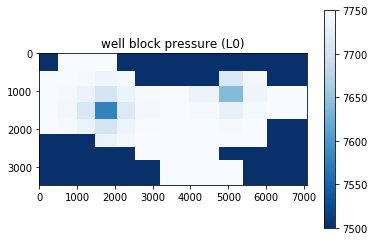

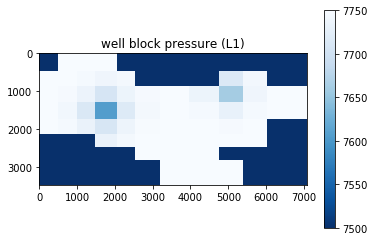

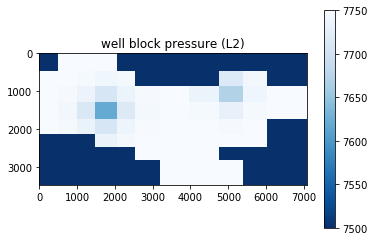

In [11]:
#Block pressure plot
import numpy as np
import matplotlib.pyplot as plt

cor = []

x_cor = 0

for ix in range (0,Nx):
    if ix == 0:
        x_cor += dx[iz,0,ix]/2    
    else:
        x_cor += dx[iz,0,ix-1]/2 + dx[iz,0,ix]/2
    y_cor = 0
    for iy in range (0,Ny):
        if iy == 0:
            y_cor += dy[iz,iy,0]/2  
            cor.append([x_cor,y_cor])
        else:
            y_cor += dy[iz,iy,0]/2 + dy[iz,iy-1,0]/2
            cor.append([x_cor,y_cor])
                
    
cor_array = np.array(cor)

pressure_L0 = []
pressure_L1 = []
pressure_L2 = []

for ix in range (0,Nx):
    for iy in range (0,Ny):
        pressure_L0.append(p_new[0,iy,ix])
        pressure_L1.append(p_new[1,iy,ix])
        pressure_L2.append(p_new[2,iy,ix])

pressure_array_L0 = np.array(pressure_L0)
pressure_array_L1 = np.array(pressure_L1)
pressure_array_L2 = np.array(pressure_L2)

grid_x, grid_y = np.mgrid[0:x_cor:100j, 0:y_cor:100j]

vmin_lower_limit = 7500
vmin_upper_limit = 7750


from scipy.interpolate import griddata
cmap = 'Blues_r'
grid_z0 = griddata(cor_array, pressure_array_L0, (grid_x, grid_y), method='nearest')

plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
plt.title('well block pressure (L0)')
plt.colorbar()
plt.show()


grid_z0 = griddata(cor_array, pressure_array_L1, (grid_x, grid_y), method='nearest')

plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
plt.title('well block pressure (L1)')
plt.colorbar()
plt.show()


grid_z0 = griddata(cor_array, pressure_array_L2, (grid_x, grid_y), method='nearest')

plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
plt.title('well block pressure (L2)')
plt.colorbar()
plt.colorbar
plt.show()

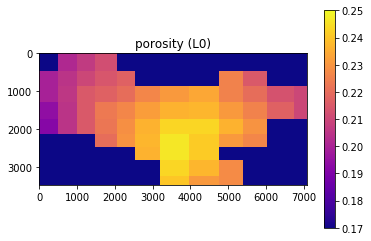

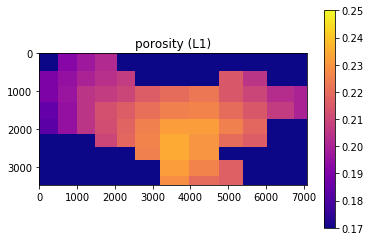

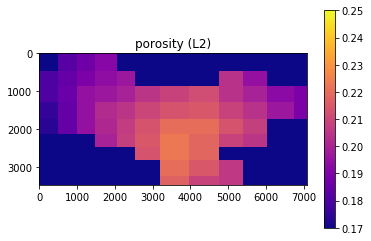

In [12]:
#Porosity map plot
import numpy as np
import matplotlib.pyplot as plt

cor = []

x_cor = 0

for ix in range (0,Nx):
    if ix == 0:
        x_cor += dx[iz,0,ix]/2    
    else:
        x_cor += dx[iz,0,ix-1]/2 + dx[iz,0,ix]/2
    y_cor = 0
    for iy in range (0,Ny):
        if iy == 0:
            y_cor += dy[iz,iy,0]/2  
            cor.append([x_cor,y_cor])
        else:
            y_cor += dy[iz,iy,0]/2 + dy[iz,iy-1,0]/2
            cor.append([x_cor,y_cor])
                
    
cor_array = np.array(cor)

porosity_L0 = []
porosity_L1 = []
porosity_L2 = []

for ix in range (0,Nx):
    for iy in range (0,Ny):
        porosity_L0.append(phi[0,iy,ix])
        porosity_L1.append(phi[1,iy,ix])
        porosity_L2.append(phi[2,iy,ix])

porosity_array_L0 = np.array(porosity_L0)
porosity_array_L1 = np.array(porosity_L1)
porosity_array_L2 = np.array(porosity_L2)

grid_x, grid_y = np.mgrid[0:x_cor:100j, 0:y_cor:100j]

vmin_lower_limit = 0.17
vmin_upper_limit = 0.25

from scipy.interpolate import griddata
grid_z0 = griddata(cor_array, porosity_array_L0, (grid_x, grid_y), method='nearest')

cmap = 'plasma'

plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
plt.title('porosity (L0)')
plt.colorbar()
plt.show()

grid_z0 = griddata(cor_array, porosity_array_L1, (grid_x, grid_y), method='nearest')


plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
plt.title('porosity (L1)')
plt.colorbar()
plt.show()

grid_z0 = griddata(cor_array, porosity_array_L2, (grid_x, grid_y), method='nearest')


plt.imshow(grid_z0.T, extent=(0,x_cor,y_cor,0),vmin=vmin_lower_limit, vmax=vmin_upper_limit,cmap=cmap)
plt.title('porosity (L2)')
plt.colorbar()
plt.show()

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Z contains NaN values. This may result in rendering artifacts.
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Z contains NaN values. This may result in rendering artifacts.
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Z contains NaN values. This may result in rendering artifacts.


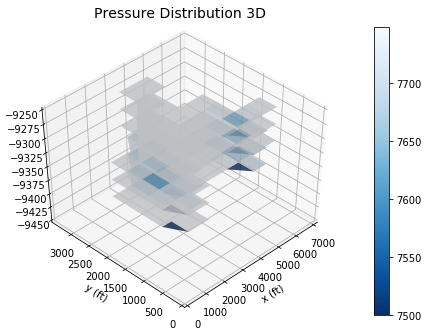

In [13]:
#Pressure Distribution (3D Map)

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x_array = []
y_array = []
z_array = []

iz = 0

x_cor = 0
for ix in range (0,Nx):
    if ix == 0:
        x_cor += dx[iz,0,ix]/2 
        x_array.append(x_cor)
    else:
        x_cor += dx[iz,0,ix-1]/2 + dx[iz,0,ix]/2
        x_array.append(x_cor)

y_cor = 0
for iy in range (0,Ny):
    if iy == 0:
        y_cor += dy[iz,iy,0]/2  
        y_array.append(y_cor)
    else:
        y_cor += dy[iz,iy,0]/2 + dy[iz,iy-1,0]/2
        y_array.append(y_cor)


for ix in range (0,Nx):
    for iy in range (0,Ny):
        z_array.append(middle[iz,iy,ix])


X, Y = np.meshgrid(x_array, y_array)
Z0 = -middle[iz,:,:]
pressure = p_new
Z0[abs(Z0)<1] = np.nan
    
#Add
Z1 = -middle[1,:,:]
pressure = p_new
Z1[abs(Z1)<1] = np.nan

#Add
Z2 = -middle[2,:,:]
pressure = p_new
Z2[abs(Z2)<1] = np.nan
    
fig = plt.figure()

ax = Axes3D(fig)
#ax = fig.add_subplot(111, projection='3d')
ax.view_init(45,45)
ax.set_xlim3d(abs(np.max(X)),0)
ax.set_ylim3d(abs(np.max(Y)),0)
ax.set_zlim3d(-9450,-9250)
# here we create the surface plot, but pass V through a colormap
# to create a different color for each patch
norm = matplotlib.colors.Normalize(vmin=7500, vmax=7750)
ax.plot_surface(X, Y, Z0, facecolors = cm.Blues_r(norm(pressure[iz,:,:])),linewidth=0.1,alpha = 0.8)
ax.plot_surface(X, Y, Z1, facecolors = cm.Blues_r(norm(pressure[1,:,:])),linewidth=0.1,alpha = 0.8)
ax.plot_surface(X, Y, Z2, facecolors = cm.Blues_r(norm(pressure[2,:,:])),linewidth=0.1,alpha = 0.8)
#fig.colorbar(fig,shrink=0.5, aspect=5)

plt.title('Pressure Distribution 3D',fontsize='14', y=1.1)
plt.xlabel('x (ft)')
plt.ylabel('y (ft)')

pressure_range = np.arange(7500,7750)
m = cm.ScalarMappable(cmap=cm.Blues_r)
m.set_array(pressure_range)
plt.colorbar(m)

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: UserWarning: Z contains NaN values. This may result in rendering artifacts.
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: UserWarning: Z contains NaN values. This may result in rendering artifacts.
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Z contains NaN values. This may result in rendering artifacts.


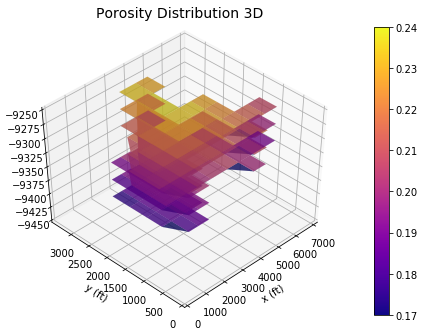

In [14]:
#Porosity Distribution (3D Map)

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x_array = []
y_array = []
z_array = []

iz = 0

x_cor = 0
for ix in range (0,Nx):
    if ix == 0:
        x_cor += dx[iz,0,ix]/2 
        x_array.append(x_cor)
    else:
        x_cor += dx[iz,0,ix-1]/2 + dx[iz,0,ix]/2
        x_array.append(x_cor)

y_cor = 0
for iy in range (0,Ny):
    if iy == 0:
        y_cor += dy[iz,iy,0]/2  
        y_array.append(y_cor)
    else:
        y_cor += dy[iz,iy,0]/2 + dy[iz,iy-1,0]/2
        y_array.append(y_cor)


for ix in range (0,Nx):
    for iy in range (0,Ny):
        z_array.append(middle[iz,iy,ix])


X, Y = np.meshgrid(x_array, y_array)
Z0 = -middle[iz,:,:]
pressure = p_new
Z0[abs(Z0)<1] = np.nan
    
#Add
Z1 = -middle[1,:,:]
pressure = p_new
Z1[abs(Z1)<1] = np.nan

#Add
Z2 = -middle[2,:,:]
pressure = p_new
Z2[abs(Z2)<1] = np.nan
    
fig = plt.figure()

ax = Axes3D(fig)
#ax = fig.add_subplot(111, projection='3d')
ax.view_init(45,45)
ax.set_xlim3d(abs(np.max(X)),0)
ax.set_ylim3d(abs(np.max(Y)),0)
ax.set_zlim3d(-9450,-9250)
# here we create the surface plot, but pass V through a colormap
# to create a different color for each patch
norm = matplotlib.colors.Normalize(vmin=0.17, vmax=0.25)

ax.plot_surface(X, Y, Z0, facecolors = cm.plasma(norm(phi[iz,:,:])),linewidth=0.1,alpha = 0.8)
ax.plot_surface(X, Y, Z1, facecolors = cm.plasma(norm(phi[1,:,:])),linewidth=0.1,alpha = 0.8)
ax.plot_surface(X, Y, Z2, facecolors = cm.plasma(norm(phi[2,:,:])),linewidth=0.1,alpha = 0.8)
#fig.colorbar(fig,shrink=0.5, aspect=5)
plt.title('Porosity Distribution 3D',fontsize='14', y=1.1)
plt.xlabel('x (ft)')
plt.ylabel('y (ft)')

porosity_range = np.arange(0.17,0.25,0.01)
m = cm.ScalarMappable(cmap=cm.plasma)
m.set_array(porosity_range)
plt.colorbar(m)

In [15]:
#for testing purpose
R_matrix = np.zeros((Nz,Ny,Nx))
for iz in range (0,Nz):
    for iy in range (0,Ny):
        for ix in range (0,Nx):
            R_matrix[iz,iy,ix] = R(iz,iy,ix,'0')
        
R_matrixW = np.zeros((Nz,Ny,Nx))
for iz in range (0,Nz):
    for iy in range (0,Ny):
        for ix in range (0,Nx):
            R_matrixW[iz,iy,ix] = R(iz,iy,ix,'W')
        
#print(R_matrix)
#print(R_matrixW)

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in 

In [16]:
#for testing purpose
dRdp_matrixC = np.zeros((Nz,Ny,Nx))
for iz in range (0,Nz):
    for iy in range (0,Ny):
        for ix in range (0,Nx):
            dRdp_matrixC[iz,iy,ix] = dR_dp(iz,iy,ix,'C')
#print(dRdp_matrixC)

dRdp_matrixW = np.zeros((Nz,Ny,Nx))
for iz in range (0,Nz):
    for iy in range (0,Ny):
        for ix in range (0,Nx):
            dRdp_matrixW[iz,iy,ix] = dR_dp(iz,iy,ix,'W')
#print(dRdp_matrixW)

C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Kittipong Limchuchua\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in 

In [17]:
#print(residual_dp)